<a href="https://colab.research.google.com/github/marianna718/Repo_1/blob/main/vae_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt 
from tensorflow import keras
import keras.backend as K

from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
    
data, attrs = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [ ]:
attrs['Smiling']

0        -0.86499
1        0.798544
2        0.172817
3        0.563327
4        0.507786
           ...   
13138   -1.001434
13139    -0.64957
13140    0.475018
13141    0.741653
13142   -1.667977
Name: Smiling, Length: 13143, dtype: object

In [ ]:
x_train = data[:10000]
X_train = data[:10000].reshape((10000, -1))

print(X_train.shape)
x_val = data[10000:]
X_val = data[10000:].reshape((-1, X_train.shape[1]))

print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [ ]:
x_train = np.float32(x_train)
x_train = x_train/255
x_val = np.float32(x_val)
x_val = x_val/255

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

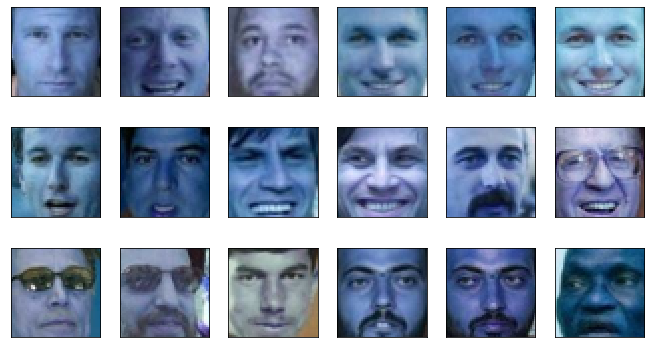

In [ ]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [ ]:
dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?


input_img = Input((45,45,3))

x = Flatten()(input_img)
x = Dense(128,activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
encoded_a = Dense(49,activation = 'relu')(x)

d = Dense(64, activation = 'relu')(encoded_a)
d = Dense(45*45*3, activation = 'sigmoid')(d)
decoded_a = Reshape((45,45,3))(d)

autoencoder = keras.Model(input_img, decoded_a , name ='autoencoder')
# Define the decoder and encoder as networks with one hidden fc-layer


# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics
 

In [ ]:
# Train your autoencoder
import tensorflow as tf
batch_size = 100
autoencoder.compile(optimizer = 'adam', loss =tf.keras.losses.MeanSquaredError(name='mean_squared_error'))
autoencoder.fit(x_train, x_train, epochs=50, batch_size= batch_size, shuffle = True)

# Visualize progress in reconstruction and loss decay


Epoch 1/50
100/100 [==============================] - 4s 29ms/step - loss: 0.0260
Epoch 2/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0172
Epoch 3/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0150
Epoch 4/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0136
Epoch 5/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0127
Epoch 6/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0122
Epoch 7/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0114
Epoch 8/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0110
Epoch 9/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0103
Epoch 10/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0101
Epoch 11/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0095
Epoch 12/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0093
Epoch 13/50
1

1/1 [==============================] - 0s 274ms/step


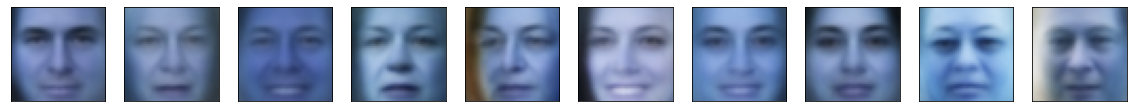

In [ ]:
 # Examine the c
n = 10
imgs = x_val[:n]
decoded_imgs = autoencoder.predict(x_val[:n], batch_size = n)

plt.figure(figsize = (2*n ,4))
for i in range(n):
  # ax = plt.subplot(1,n,i +1)
  # plt.imshow(imgs[i].squeeze(),cmap= 'gray')
  # ax.get_xaxis().set_visible(False)
  # ax.get_yaxis().set_visible(False)

  ax2 = plt.subplot(2, n, i+1 )
  plt.imshow(decoded_imgs[i].squeeze(),cmap = 'gray')
  ax2.get_xaxis().set_visible(False)
  ax2.get_yaxis().set_visible(False)

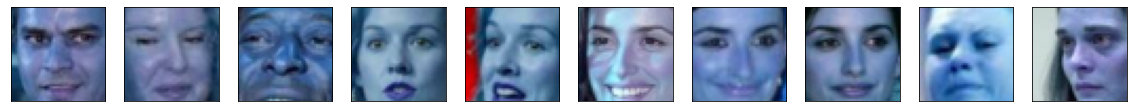

In [ ]:
n = 10
imgs = x_val[:n]
# decoded_imgs = autoencoder.predict(x_val[:n], batch_size = n)

plt.figure(figsize = (2* n ,2))
for i in range(n):
  ax = plt.subplot(1,n,i +1)
  plt.imshow(imgs[i].squeeze(),cmap= 'gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

Reconstruction is not bad, right? 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

In [ ]:
z = np.random.randn(25, dimZ)*0.5
output = None # FIXME compute from decoder from z
# plot_gallery(output, image_h, image_w, n_row=5, n_col=5)
# for this cells result look upwords

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input ,Lambda ,BatchNormalization ,Dropout

In [ ]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 100


dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?
""" batch normalization and dropout are for making the learning proess kind of slower and "yndhanracman" hamar
x -> Batch normalization -> Dropout
 """
hidden_dim = 2
batch_size = 100 #? shukd be divideable to num of photos i hope

def dropout_and_batch(x):
  return Dropout(0.3)(BatchNormalization()(x))

input_img = Input(batch_shape = (batch_size , 45,45,3))
x = Flatten()(input_img)
# print(x,"1")
x = Dense(256, activation  ='relu')(x)
# print(x,"2")
x = dropout_and_batch(x)
# print(x,"3")
x = Dense(128, activation = 'relu')(x)
# print(x,"4")
x = dropout_and_batch(x)
# print(x,"5")

z_mean = Dense(hidden_dim)(x)
# print(z_mean,"5")
z_log_var = Dense(hidden_dim)(x)
# print(z_log_var,"5")
""" the first is matspasum and the second is dispersian , morever the dispersia is taken with log , for confortability \
and the size is respectfuly the size of our hidden lier , h1,h2, ... 
we will use some lambda function for creating our h vector , and it will get the next 
z_mean, z_log_var : (batch_size, hidden_dim)  and will return h: (batch_size , hidden_dim)"""

#  h = Lambda (noiser, output_shape = (hidden_dim))([z_mean, z_log_var])
def noiser(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  # h = disp * N * mean
  N = K.random_normal(shape = (batch_size, hidden_dim),mean = 0., stddev = 1.0) #we are generating normal tensor with size (batch_size , hidden _dim)
  #now we shuld do the next step
  #exp(log disp^2/2) = exp(log disp ) = disp
  return K.exp(z_log_var/2)* N + z_mean

  """The noiser function is for the miidle part of my network , there it takes some 
  z vectors wivh are just generated noises , and then multiplies it vith dispersion and adds matspasum,
  then it is taken to decoder as a noisy vector"""

h = Lambda(noiser,output_shape =(hidden_dim))([z_mean, z_log_var])
  #this was the encoder part
#now dear friends lets create our decoder

input_dec = Input(shape = (hidden_dim,))
d = Dense(128, activation ='relu')(input_dec)
# print(input_dec.shape,"1.")
# print(d.shape,"2.")
d = dropout_and_batch(d)
# print(d.shape,"3,")
d = Dense(256, activation = 'relu')(input_dec)
# print(input_dec.shape,"4.")
d = Dense(45*45*3, activation = 'sigmoid')(d) 
decoded = Reshape((45,45,3))(d)

encoder_V = keras.Model(input_img, h, name = 'encoder')
decoder_V = keras.Model(input_dec, decoded, name = 'decoder')
vae = keras.Model(input_img, decoder_V(encoder_V(input_img)), name = "vae")




# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [ ]:
def KL_divergence(mu, logsigma):
    return 0

def log_likelihood(x, mu, logsigma):
    return 0

def loss_vae(x,y):
  x = K.reshape(x, shape = (batch_size,45*45*3))  #reshapeing both arrays to 2d 
  y = K.reshape(y, shape = (batch_size, 45*45*3))
  loss = K.sum(K.square(x - y), axis = -1) #we are counting the difference between the input and output and sum up the results
  kl_loss = -0.5 * K.sum(1 +z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1) #this is the next part of loss # divergation of Kulda koleybera
  return loss + kl_loss

  

And train the model:

In [ ]:
# train your autoencoder

vae.compile(optimizer = 'adam', loss = loss_vae)
vae.fit(x_train, x_train, epochs = 50, batch_size= batch_size, shuffle = True  )
# visualize progress in reconstruction and loss decay

Epoch 1/50
100/100 [==============================] - 7s 58ms/step - loss: 151.8563
Epoch 2/50
100/100 [==============================] - 6s 57ms/step - loss: 122.1828
Epoch 3/50
100/100 [==============================] - 6s 58ms/step - loss: 115.0199
Epoch 4/50
100/100 [==============================] - 6s 57ms/step - loss: 111.8584
Epoch 5/50
100/100 [==============================] - 6s 57ms/step - loss: 109.9762
Epoch 6/50
100/100 [==============================] - 6s 57ms/step - loss: 109.0432
Epoch 7/50
100/100 [==============================] - 6s 58ms/step - loss: 107.9841
Epoch 8/50
100/100 [==============================] - 6s 58ms/step - loss: 107.5407
Epoch 9/50
100/100 [==============================] - 6s 57ms/step - loss: 107.1586
Epoch 10/50
100/100 [==============================] - 6s 57ms/step - loss: 107.0848
Epoch 11/50
100/100 [==============================] - 6s 57ms/step - loss: 107.2174
Epoch 12/50
100/100 [==============================] - 6s 59ms/step - loss

10/10 [==============================] - 0s 10ms/step


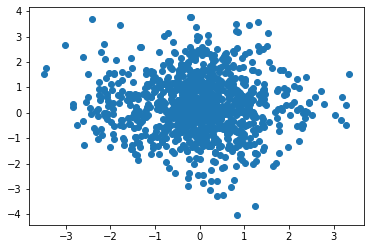

In [ ]:
h = encoder_V.predict(x_val[:1000], batch_size= batch_size)
plt.scatter(h[:,0], h[:,1]) 


1/1 [==============================] - 0s 17ms/step


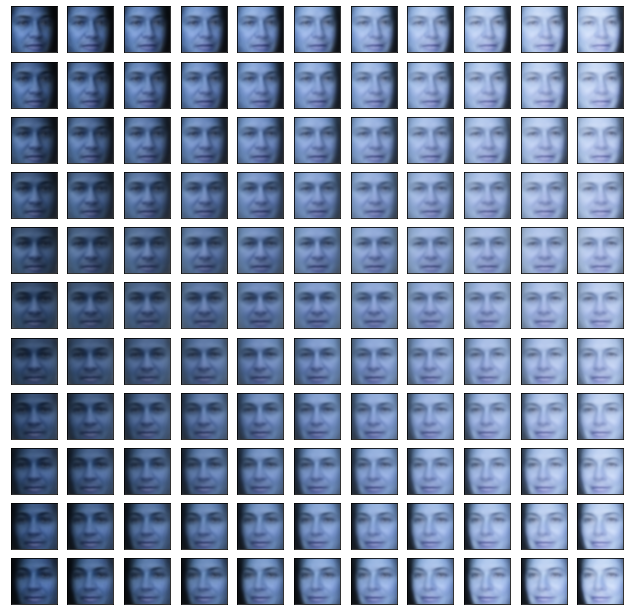

In [ ]:
# test your autoencoder with validation data

n = 5
total = 2*n+1
plt.figure(figsize = (total, total))

num = 1
for i in range(-n,n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total,total,num)
    num += 1
    img = decoder_V.predict(np.expand_dims([3*i/n, 3*j/n], axis = 0))
    plt.imshow(img.squeeze(), cmap ='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

And finally sample from VAE.

In [ ]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

WITH VAE

In [ ]:
Smilers = np.sort(attrs["Smiling"])
smile_ind = np.argsort(attrs["Smiling"])

In [ ]:
sadik = smile_ind[:10]
Smilers[:10]

array([-2.68659390331, -2.66448393851, -2.6435466389, -2.63974939798,
       -2.6307687685, -2.58931919584, -2.58913129363, -2.55586784498,
       -2.54272801506, -2.54102410301], dtype=object)

In [ ]:
smilik = smile_ind[-10:]
Smilers[-10:]

array([2.67085081779, 2.67717763675, 2.68315646478, 2.71662975695,
       2.71720999251, 2.73703783578, 2.74381721985, 2.78114626985,
       2.79182982449, 2.83999377045], dtype=object)

In [ ]:
sadik

0    11571
1     1234
2     7506
3     5458
4     7065
5    11912
6     1654
7      471
8     8410
9     8596
Name: Smiling, dtype: int64

In [ ]:
smiling = data[smilik]
non_smiling = data[sadik]

In [ ]:
input_img = Input(batch_shape = (10 , 45,45,3))
x = Flatten()(input_img)
# print(x,"1")
x = Dense(256, activation  ='relu')(x)
# print(x,"2")
x = dropout_and_batch(x)
# print(x,"3")
x = Dense(128, activation = 'relu')(x)
# print(x,"4")
x = dropout_and_batch(x)
# print(x,"5")

z_mean = Dense(hidden_dim)(x)
# print(z_mean,"5")
z_log_var = Dense(hidden_dim)(x)
# print(z_log_var,"5")
""" the first is matspasum and the second is dispersian , morever the dispersia is taken with log , for confortability \
and the size is respectfuly the size of our hidden lier , h1,h2, ... 
we will use some lambda function for creating our h vector , and it will get the next 
z_mean, z_log_var : (batch_size, hidden_dim)  and will return h: (batch_size , hidden_dim)"""

#  h = Lambda (noiser, output_shape = (hidden_dim))([z_mean, z_log_var])
def noiser(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  # h = disp * N * mean
  N = K.random_normal(shape = (10, hidden_dim),mean = 0., stddev = 1.0) #we are generating normal tensor with size (batch_size , hidden _dim)
  #now we shuld do the next step
  #exp(log disp^2/2) = exp(log disp ) = disp
  return K.exp(z_log_var/2)* N + z_mean

  """The noiser function is for the miidle part of my network , there it takes some 
  z vectors wivh are just generated noises , and then multiplies it vith dispersion and adds matspasum,
  then it is taken to decoder as a noisy vector"""

h = Lambda(noiser,output_shape =(hidden_dim))([z_mean, z_log_var])
  #this was the encoder part
#now dear friends lets create our decoder

input_dec = Input(shape = (hidden_dim,))
d = Dense(128, activation ='relu')(input_dec)
# print(input_dec.shape,"1.")
# print(d.shape,"2.")
d = dropout_and_batch(d)
# print(d.shape,"3,")
d = Dense(256, activation = 'relu')(input_dec)
# print(input_dec.shape,"4.")
d = Dense(45*45*3, activation = 'sigmoid')(d) 
decoded = Reshape((45,45,3))(d)

encoder_V = keras.Model(input_img, h, name = 'encoder')
decoder_V = keras.Model(input_dec, decoded, name = 'decoder')
vae = keras.Model(input_img, decoder_V(encoder_V(input_img)), name = "vae")



In [ ]:
smile_vect = encoder_V.predict(smiling)
non_smile_vect = encoder_V.predict(non_smiling)

1/1 [==============================] - 0s 26ms/step


In [ ]:
smile_vect

array([[ 1.6276208e+11, -7.0889554e+28],
       [-2.4013959e+02,  4.6371858e+22],
       [ 6.1293404e+14, -3.0700969e+17],
       [ 6.1104446e+15, -1.4595610e+18],
       [ 4.7687363e+02, -4.0926483e+32],
       [-5.3440680e+07,  3.1027102e+22],
       [-5.0961957e+21, -2.8292034e+27],
       [-6.2948733e+10,  1.0455164e+28],
       [-1.0536449e+03,  2.6934875e+32],
       [ 3.2691865e+17, -1.0153474e+34]], dtype=float32)

In [ ]:
diff = smile_vect - non_smile_vect
dif = diff.mean()
# m1 = smile_vect.mean()
# m2 = non_smile_vect.mean()
# dif2 = m1-m2

In [ ]:
unhappy_person = smile_ind[12]
Smilers[12]

-2.50553682237

(45, 45, 3)

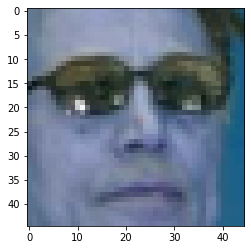

In [ ]:
img = data[12]
plt.imshow(img, cmap="gray", interpolation="none")
img.shape

In [ ]:
enc = encoder_V.predict(data[11:21])
print(enc.shape)
print(enc[0])
# forced_smile = enc + dif
enc[0] += dif
print(enc[0])
result = decoder_V.predict(enc)

1/1 [==============================] - 0s 19ms/step
(10, 2)
[-1.1902908e+02  1.4299690e+13]
[-5.1466622e+32 -5.1466622e+32]
1/1 [==============================] - 0s 20ms/step


In [ ]:

# encoder_V.compile(optimizer = 'adam', loss =tf.keras.losses.MeanSquaredError(name='mean_squared_error'))
# autoencoder.fit(x_train, x_train, epochs=50, batch_size= batch_size, shuffle = True

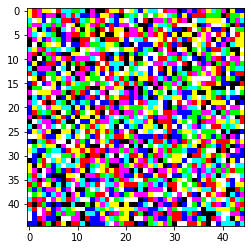

In [ ]:
plt.imshow(result[0], cmap="gray", interpolation="none")


In [ ]:
result.shape


(45, 45, 45, 3)

WITH AE

So as u can see if we just do "smile" vector minus "non-smile" vector we wont got any good results , becouse its just too obviusly anlogical:))


In [ ]:
input_img = Input((45,45,3))

x = Flatten()(input_img)
x = Dense(128,activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
encoded_a = Dense(49,activation = 'relu')(x)

d = Dense(64, activation = 'relu')(encoded_a)
d = Dense(45*45*3, activation = 'sigmoid')(d)
decoded_a = Reshape((45,45,3))(d)



encoder = keras.Model(input_img, encoded_a, name = 'encoder')
decoder = keras.Model(encoded_a, decoded_a, name = 'decoder')
autoencoder = keras.Model(input_img, decoded_a , name ='autoencoder')


In [ ]:
smile_vect = encoder.predict(smiling)
non_smile_vect = encoder.predict(non_smiling)

1/1 [==============================] - 0s 26ms/step


In [ ]:
diff = smile_vect - non_smile_vect
dif = diff.mean()
d

(45, 45, 3)

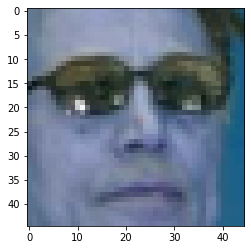

In [ ]:
img = data[12]
plt.imshow(img, cmap="gray", interpolation="none")
img.shape

In [ ]:
# enc = encoder.predict(img)
input_img = np.expand_dims(img, axis = 0)

x = Flatten()(input_img)
print(x.shape)
x = Dense(128,activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
encoded_a = Dense(49,activation = 'relu')(x)

print(encoded_a.shape)
forced_smile = encoded_a + dif
print(forced_smile.shape)


d = Dense(128, activation = 'relu')(forced_smile)
print(d.shape)
d = Dense(45*45*3, activation = 'sigmoid')(d)
print(d.shape)
decoded_a = Reshape((45,45,3))(d)
decoded_a.shape

# result = decoder_V.predict(forced_smile)

(1, 6075)
(1, 49)
(1, 49)
(1, 128)
(1, 6075)


TensorShape([1, 45, 45, 3])

<tf.Tensor: shape=(1, 45, 45, 3), dtype=float32, numpy=
array([[[[2.63766259e-01, 7.22423077e-01, 6.60787001e-02],
         [5.21832824e-01, 4.90666851e-02, 9.53946054e-01],
         [1.64237216e-01, 4.64749008e-01, 1.90286309e-01],
         ...,
         [9.81030911e-02, 9.92700636e-01, 6.19056402e-04],
         [9.99888003e-01, 2.46482920e-02, 4.14654904e-04],
         [9.83977079e-01, 9.95163321e-01, 1.28144480e-03]],

        [[9.98040497e-01, 1.33711159e-01, 1.75168484e-01],
         [9.99532878e-01, 9.99941647e-01, 9.41893041e-01],
         [9.58964825e-01, 9.99994397e-01, 1.65421963e-02],
         ...,
         [4.35794502e-01, 3.55726224e-03, 9.92106140e-01],
         [6.85368292e-03, 9.99639392e-01, 7.96206295e-01],
         [2.23573577e-02, 9.98067498e-01, 8.17547971e-07]],

        [[1.07400557e-02, 9.19688582e-01, 9.97990191e-01],
         [2.50778019e-01, 9.99970913e-01, 9.77532387e-01],
         [2.77043460e-03, 9.47076142e-01, 9.84184325e-01],
         ...,
         [8.4

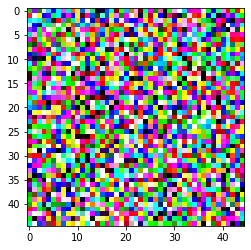

In [ ]:
plt.imshow(decoded_a[0], cmap="gray", interpolation="none")
# plt.imshow(decoded_a.squeeze(), cmap ='gray')

decoded_a

##CONCLUSSION
Iwold like to recive some fidback about 'why dosent this work for me'

In [ ]:
# Thank you  

In [ ]:
# Byeeeee